<a href="https://colab.research.google.com/github/vsbca/Data-Science/blob/master/PySpark_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 1 - <br/>
Install Spark, download datasets, create final dataframe. If you get an error regarding tar or wget, it is probably due to the Spark file being removed from the repository. <br/>
Go to https://downloads.apache.org/spark/ and choose an equivalent version of Spark and Hadoop to download. So if 2.4.7 is not available, download the next version. At the time of this project creation, 2.4.7 exists.

In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [6]:
import findspark
findspark.init()

#Import colab
from google.colab import files
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import isnan, when, count, col, lit, trim, avg, ceil
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



In [7]:
!wget https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv -O features.csv
!wget https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv -O labels.csv

--2020-12-14 19:46:07--  https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.73.54
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.73.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20069199 (19M) [text/csv]
Saving to: ‘features.csv’

features.csv        100%[===================>]  19.14M  38.4MB/s    in 0.5s    

2020-12-14 19:46:08 (38.4 MB/s) - ‘features.csv’ saved [20069199/20069199]

--2020-12-14 19:46:08--  https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.10.14
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.10.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148327 (1.1M) [text/csv]
Saving to: ‘labels.csv’

labels.csv          100%[===================>]   1.09M  --.-KB/s    in 0.08s   

2020-12-14 19:46:08 (13.6 MB

In [8]:
!ls -l

total 248600
-rw-r--r--  1 root root  20069199 Feb  2  2015 features.csv
-rw-r--r--  1 root root   1148327 Feb  2  2015 labels.csv
drwxr-xr-x  1 root root      4096 Dec  2 22:04 sample_data
drwxr-xr-x 13 1000 1000      4096 Sep  8 05:48 spark-2.4.7-bin-hadoop2.7
-rw-r--r--  1 root root 233333392 Sep  8 07:13 spark-2.4.7-bin-hadoop2.7.tgz


In [9]:
#Run Spark Locally
sc = SparkSession.builder.master("local[*]").getOrCreate()


In [10]:
feature = sc.read.csv("features.csv", inferSchema=True, header=True)
label = sc.read.csv("labels.csv",inferSchema=True, header=True)


In [11]:
#Print the count
print(feature.count())
print(label.count())
print(feature.columns)
print(label.columns)

59400
59400
['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
['id', 'status_group']


In [12]:
data= feature.join(label, on=("id"))
#What is the data here
print(data.count())
print(data.columns)

59400
['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [13]:
#print schema
print(data.printSchema())

root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: timestamp (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: integer (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- district_code: integer (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: boolean (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: boolean (nullable = true)
 |-- construction_year: integer (nullable

In [14]:
#Show top 10 rows
data.show(10)

+-----+----------+-------------------+-------------------+----------+------------+-----------+------------+--------------------+-----------+--------------------+---------------+---------+-----------+-------------+---------------+----------+----------+--------------+--------------------+-----------------+--------------------+------+-----------------+---------------+---------------------+---------------------+----------+----------------+--------------+------------+-------------+-------------+------------+--------------+--------------------+--------------------+------------+--------------------+---------------------+--------------+
|   id|amount_tsh|      date_recorded|             funder|gps_height|   installer|  longitude|    latitude|            wpt_name|num_private|               basin|     subvillage|   region|region_code|district_code|            lga|      ward|population|public_meeting|         recorded_by|scheme_management|         scheme_name|permit|construction_year|extraction_t

In [15]:
#Change the dataType
data = data.withColumn("region_code", col("region_code").cast(StringType()))
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: timestamp (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: integer (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: string (nullable = true)
 |-- district_code: integer (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: boolean (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: boolean (nullable = true)
 |-- construction_year: integer (nullable 

In [16]:
#Drop the duplicate values
data = data.dropDuplicates(["id"])
data.count()

59400

In [17]:
#Trimming the string data type column values
str_cols = [item[0] for item in data.dtypes if item[1].startswith('string')]
for cols in str_cols:
  data = data.withColumn(cols, trim(data[cols]))

In [18]:
#Task3: Count for the nan/null values
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns if c not in {'date_recorded', 'public_meeting','permit'}]).show(vertical=True)

-RECORD 0----------------------
 id                    | 0     
 amount_tsh            | 0     
 funder                | 3635  
 gps_height            | 0     
 installer             | 3655  
 longitude             | 0     
 latitude              | 0     
 wpt_name              | 0     
 num_private           | 0     
 basin                 | 0     
 subvillage            | 371   
 region                | 0     
 region_code           | 0     
 district_code         | 0     
 lga                   | 0     
 ward                  | 0     
 population            | 0     
 recorded_by           | 0     
 scheme_management     | 3877  
 scheme_name           | 28166 
 construction_year     | 0     
 extraction_type       | 0     
 extraction_type_group | 0     
 extraction_type_class | 0     
 management            | 0     
 management_group      | 0     
 payment               | 0     
 payment_type          | 0     
 water_quality         | 0     
 quality_group         | 0     
 quantit

In [19]:
#Let's collect the above result in new data frame
df2 = data.select([(count(when(isnan(c) | col(c).isNull(), c))/data.count()).alias(c) for c in data.columns if c not in {'date_recorded', 'public_meeting','permit'}]).collect()

In [20]:
#Print the type
type(df2)

list

In [21]:
agg_dict_list = [row.asDict() for row in df2]
agg_dict = agg_dict_list[0]

In [22]:
col_null = list({i for i in agg_dict if agg_dict[i] > 0.4 })
print(agg_dict)
print(col_null)
#Drop the null column with higher threshold
data = data.drop(*col_null)

{'id': 0.0, 'amount_tsh': 0.0, 'funder': 0.0611952861952862, 'gps_height': 0.0, 'installer': 0.061531986531986535, 'longitude': 0.0, 'latitude': 0.0, 'wpt_name': 0.0, 'num_private': 0.0, 'basin': 0.0, 'subvillage': 0.0062457912457912455, 'region': 0.0, 'region_code': 0.0, 'district_code': 0.0, 'lga': 0.0, 'ward': 0.0, 'population': 0.0, 'recorded_by': 0.0, 'scheme_management': 0.06526936026936027, 'scheme_name': 0.4741750841750842, 'construction_year': 0.0, 'extraction_type': 0.0, 'extraction_type_group': 0.0, 'extraction_type_class': 0.0, 'management': 0.0, 'management_group': 0.0, 'payment': 0.0, 'payment_type': 0.0, 'water_quality': 0.0, 'quality_group': 0.0, 'quantity': 0.0, 'quantity_group': 0.0, 'source': 0.0, 'source_type': 0.0, 'source_class': 0.0, 'waterpoint_type': 0.0, 'waterpoint_type_group': 0.0, 'status_group': 0.0}
['scheme_name']


In [23]:
#Group, Aggregate and Create Pivot table
data.groupBy("recorded_by").count().show(truncate = False)

+-----------------------+-----+
|recorded_by            |count|
+-----------------------+-----+
|GeoData Consultants Ltd|59400|
+-----------------------+-----+



In [24]:
#Use orderBy and show the descending order
data.groupBy("water_quality").count().orderBy('count', ascending=False).show(truncate=False)


+------------------+-----+
|water_quality     |count|
+------------------+-----+
|soft              |50818|
|salty             |4856 |
|unknown           |1876 |
|milky             |804  |
|coloured          |490  |
|salty abandoned   |339  |
|fluoride          |200  |
|fluoride abandoned|17   |
+------------------+-----+



In [25]:
data = data.drop("recorded_by")

In [26]:
data.groupBy("status_group").pivot("region").sum("amount_tsh").show()

+--------------------+---------+-------------+------+---------+------+--------+------------------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+--------+
|        status_group|   Arusha|Dar es Salaam|Dodoma|   Iringa|Kagera|  Kigoma|       Kilimanjaro|  Lindi| Manyara|    Mara|Mbeya|Morogoro| Mtwara| Mwanza|    Pwani|   Rukwa|   Ruvuma|Shinyanga| Singida|Tabora|   Tanga|
+--------------------+---------+-------------+------+---------+------+--------+------------------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+--------+
|functional needs ...|  10280.0|          0.0|   0.0| 118400.0|   0.0|270770.0|          129248.0| 3625.0| 71315.0|   900.0|  0.0| 70005.0|36240.0|10000.0|    520.0|292980.0| 125650.0|   2200.0|  6505.0|   0.0|  4310.0|
|          functional|1125485.0|     181175.0|   0.0|5515710.0|   0.0|530725.0|         746942.25|24560.0|312745.0| 9678

In [27]:
print(str_cols)

['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [28]:
for column in str_cols:
  print(data.groupBy(column).count().orderBy('count', ascending=False).show())

+--------------------+-----+
|              funder|count|
+--------------------+-----+
|Government Of Tan...| 9084|
|                null| 3635|
|              Danida| 3114|
|              Hesawa| 2202|
|               Rwssp| 1374|
|          World Bank| 1349|
|                Kkkt| 1287|
|        World Vision| 1246|
|              Unicef| 1057|
|               Tasaf|  877|
|    District Council|  843|
|                 Dhv|  829|
|  Private Individual|  826|
|                Dwsp|  811|
|                   0|  777|
|               Norad|  765|
|     Germany Republi|  610|
|                Tcrs|  602|
|   Ministry Of Water|  590|
|               Water|  583|
+--------------------+-----+
only showing top 20 rows

None
+------------------+-----+
|         installer|count|
+------------------+-----+
|               DWE|17402|
|              null| 3655|
|        Government| 1825|
|               RWE| 1206|
|             Commu| 1060|
|            DANIDA| 1050|
|              KKKT|  898|
|  

AnalysisException: ignored

In [29]:
#Set some colors
color_status = {'functional':'green',
                'non functional': 'red',
                 'functional needs repair':'blue'
                }


In [33]:
#Create a Pandas dataframe
#slected columns
cols = ["status_group", "payment_type", "longitude", "latitude", "gps_height"]

#create Pandas dataframe with selected columns
df = data.select(cols).toPandas()


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

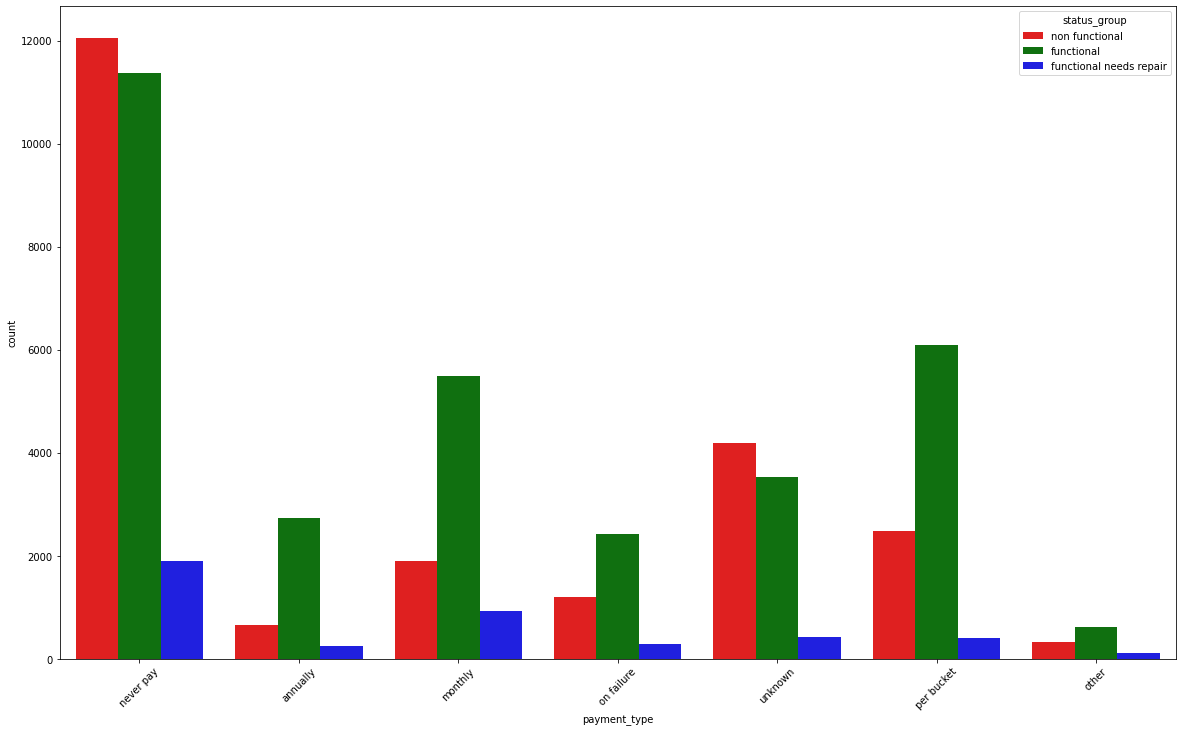

In [37]:
#Plot
fig, ax = plt.subplots(figsize=(20,12))
sns.countplot(x = 'payment_type', hue = 'status_group', data=df, ax=ax, palette=color_status)
plt.xticks(rotation=45)

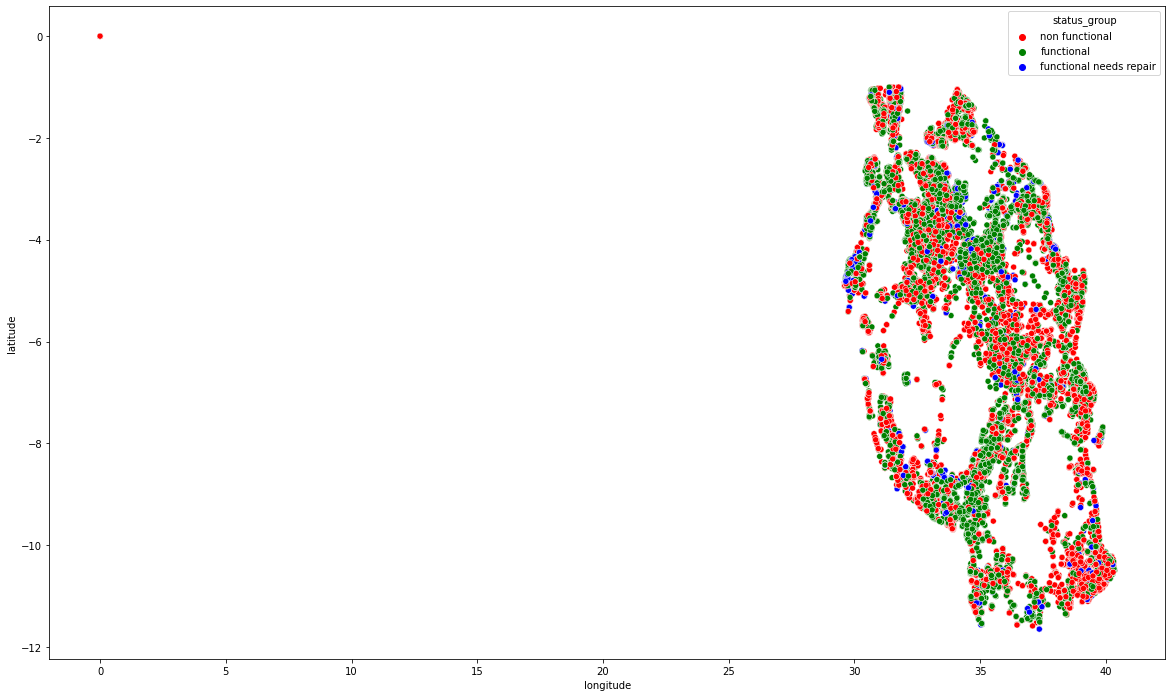

In [36]:
fig, ax = plt.subplots(figsize=(20,12))
sns.scatterplot(x='longitude', y = 'latitude', data=df, hue='status_group', ax=ax, palette=color_status)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

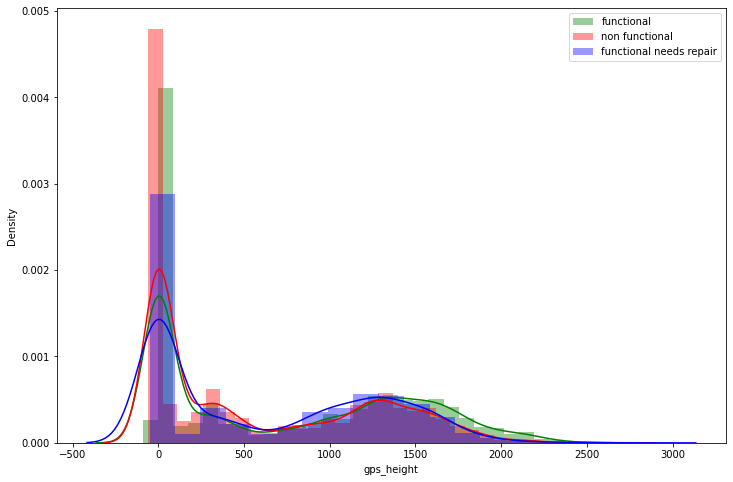

In [38]:
row_functional = (df['status_group'] == 'functional')
row_non_functional = (df['status_group'] == 'non functional')
row_repair = (df['status_group'] == 'functional needs repair')

#
col = 'gps_height'
fig,ax = plt.subplots(figsize=(12,8))

#
sns.distplot(df[col][row_functional], color='green', label='functional', ax=ax)
sns.distplot(df[col][row_non_functional], color='red', label='non functional', ax=ax)
sns.distplot(df[col][row_repair], color='blue', label="functional needs repair", ax=ax)

plt.legend()

In [40]:
df.head()

,status_group,payment_type,longitude,latitude,gps_height
0,non functional,never pay,39.124795,-9.902536,283
1,functional,annually,35.382370,-7.951232,1710
2,functional,monthly,33.850416,-8.830581,0
3,functional,never pay,30.859764,-1.478941,0
4,non functional,on failure,32.871903,-4.134065,0


In [41]:
df[col][row_functional]

1        1710
2           0
3           0
6        1167
7        2178
         ... 
59394    1322
59395       0
59397    1287
59398       8
59399    1633
Name: gps_height, Length: 32259, dtype: int32